# Generate Approximate Hessians
Use the random displacement data to get the full Hessian matrix. We assume that many parameters of the Hessian matrix are zero, and therefore that we can fit the Hessian matrix with a reduced number of points using [sparse linear regression](https://scikit-learn.org/stable/modules/linear_model.html#lasso)

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from jitterbug.model.linear import HarmonicModel
from sklearn.linear_model import LinearRegression, ElasticNetCV
from ase.vibrations import VibrationsData
from ase.db import connect
from pathlib import Path
from tqdm import tqdm
import numpy as np
import warnings

Configuration

In [2]:
molecule_name = 'water'
method = 'hf'
basis = 'def2-svpd'
step_size: float = 0.005 # Perturbation amount, used as maximum L2 norm
regressor = LinearRegression

Derived

In [3]:
run_name = f'{molecule_name}_{method}_{basis}'
out_dir = Path('data') / 'approx'
db_path = out_dir / f'{run_name}-random-d={step_size:.2e}.db'

## Read in the Data
Get all computations for the desired calculation and the exact solution

In [4]:
with connect(db_path) as db:
    data = [a.toatoms() for a in db.select('')]
print(f'Loaded {len(data)} structures')

Loaded 46 structures


Read in the exact Hessian

In [5]:
with open(f'data/exact/{run_name}-ase.json') as fp:
    exact_vibs = VibrationsData.read(fp)

In [6]:
exact_hess = exact_vibs.get_hessian_2d()
exact_zpe = exact_vibs.get_zero_point_energy()
exact_freqs = exact_vibs.get_frequencies()
print(", ".join([f'{freq.real:.2f}' for freq in exact_freqs]))

0.00, 0.00, 0.00, 0.23, 23.22, 28.26, 1713.06, 4150.63, 4258.01


## Fit a Hessian with All Data
Fit a model which explains the energy data by fitting a Hessian matrix using compressed sensing (i.e., Lasso).

In [7]:
model = HarmonicModel(reference=data[0], regressor=regressor)
hess_model = model.train(data)

In [8]:
print(f'Trained a model with {len(hess_model.coef_)} terms. {(np.abs(hess_model.coef_) > 1e-7).sum()} are nonzero')

Trained a model with 54 terms. 54 are nonzero


Compare the forces estimated at a zero displacement to the true value

In [9]:
actual_forces = data[0].get_forces()

In [10]:
pred_forces = -hess_model.coef_[:actual_forces.size].reshape((-1, 3))

In [11]:
print(f'Maximum force: {np.abs(pred_forces).max():.2e} eV/Angstrom')

Maximum force: 2.48e+10 eV/Angstrom


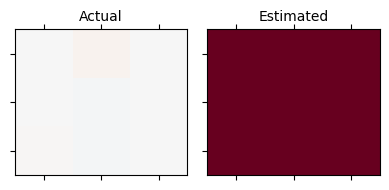

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(4, 2))

for ax, l, h in zip(axs, ['Actual', 'Estimated'], [actual_forces, pred_forces]):
    ax.matshow(h, vmin=-0.05, vmax=0.05, aspect='auto', cmap='RdBu')

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    ax.set_title(l, fontsize=10)

fig.tight_layout()

Get the mean Hessian

In [14]:
approx_hessian = model.mean_hessian(hess_model)

Compare to exact answer

In [15]:
exact_hess[:3, :3]

array([[ 7.98627522e+01, -2.06977559e-03,  4.97846696e-09],
       [-2.06977559e-03,  5.13139305e+01,  9.22094694e-07],
       [ 4.97846696e-09,  9.22094694e-07,  4.71241660e-03]])

In [16]:
approx_hessian[:3, :3]

array([[67.88647316, -5.42385004, -1.85347688],
       [-5.42385004, 44.31957259, -0.80176395],
       [-1.85347688, -0.80176395,  4.18590679]])

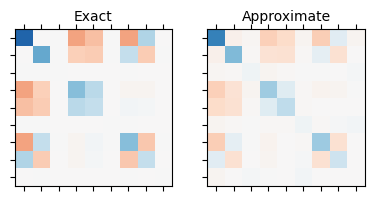

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(4, 2))

for ax, l, h in zip(axs, ['Exact', 'Approximate'], [exact_hess, approx_hessian]):
    ax.matshow(h, vmin=-100, vmax=100, cmap='RdBu')

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    ax.set_title(l, fontsize=10)

fig.tight_layout()

Get the zero point energy

In [18]:
approx_vibs = VibrationsData.from_2d(data[0], approx_hessian)

In [19]:
approx_vibs.get_zero_point_energy()

0.8339117893348411

In [20]:
print(", ".join([f'{freq.real:.2f}' for freq in approx_vibs.get_frequencies()]))

0.00, 0.09, 368.43, 775.43, 1228.11, 1788.91, 2207.24, 3503.98, 3579.71


In [21]:
freq_diff = [app_freq.real-ex_freq.real for app_freq, ex_freq in zip(approx_vibs.get_frequencies(), exact_freqs)]


/Users/elliott/miniconda3/envs/jitterbug/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


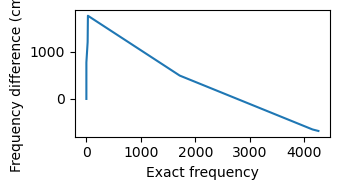

In [22]:
fig, ax = plt.subplots(figsize=(3.5, 2))

ax.plot(exact_freqs, freq_diff)

ax.set_xlabel('Exact frequency')
ax.set_ylabel('Frequency difference (cm-1)')

fig.tight_layout()

In [23]:
exact_zpe

0.6306709113107619

The two differ, but I'm not sure how important the difference is.

## Plot as a Function of Data
See what happens as we add more data to the training

In [24]:
steps = np.linspace(5, len(data), 16, dtype=int)
print(f'Plotting at {len(steps)} steps: {", ".join(map(str, steps[:5]))}, ...')

Plotting at 16 steps: 5, 7, 10, 13, 15, ...


In [25]:
zpes = []
freqs = []
freq_diffs = []
for count in tqdm(steps):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        hess_model = model.train(data[:count])
    
    approx_hessian = model.mean_hessian(hess_model)
    approx_vibs = VibrationsData.from_2d(data[0], approx_hessian)
    zpes.append(approx_vibs.get_zero_point_energy())
    freqs.append(approx_vibs.get_frequencies())
    freq_diffs.append([app_freq.real-ex_freq.real for app_freq, ex_freq in zip(approx_vibs.get_frequencies(), exact_freqs)])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 104.75it/s]


Plot it

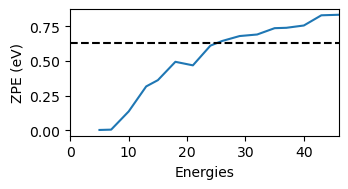

In [26]:
fig, ax = plt.subplots(figsize=(3.5, 2))

ax.plot(steps, zpes)

ax.set_xlim([0, steps.max()])
ax.plot(ax.get_xlim(), [exact_zpe]*2, 'k--')

ax.set_xlabel('Energies')
ax.set_ylabel('ZPE (eV)')

fig.tight_layout()

We consistently underestimate the ZPE. Is it because we have too few oscillators?

/Users/elliott/miniconda3/envs/jitterbug/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


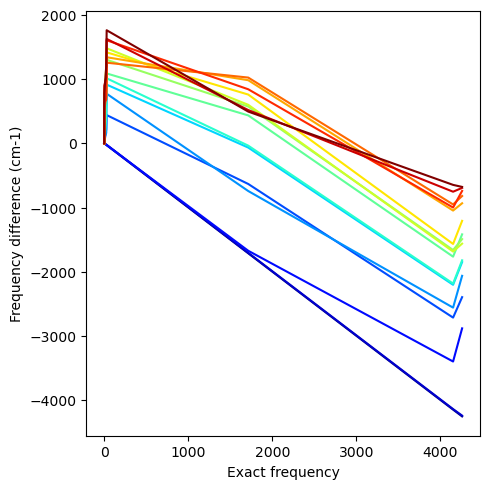

In [27]:
import matplotlib.pylab as pl

fig, ax = plt.subplots(figsize=(5, 5))
colors = pl.cm.jet(np.linspace(0,1,len(freq_diffs)))

for i, freq_diff in enumerate(freq_diffs):
    ax.plot(exact_freqs, freq_diff, color=colors[i])

ax.set_xlabel('Exact frequency')
ax.set_ylabel('Frequency difference (cm-1)')

fig.tight_layout()
    